# Predicción de daños en el pavimento en formato CRDDC 2022

En este notebook se hacen las predicciones para la CRDDC 2022.

In [1]:
# Import libraries
import time
import os
from tqdm import tqdm
from ultralytics import YOLO
import pandas as pd

In [2]:
# Constantes
REGION = 'United_States'
PATH = os.path.join('../data/rdd2022-DatasetNinja', REGION, 'test/images')
PATH_MODEL = '../runs/detect/gcolab_very_large_United_States_cvNO_120ex15b_pt/weights/best.pt'
MODEL_NAME = PATH_MODEL.split('/')[-3]
PRED_PATH = f'../predictions/{MODEL_NAME}/{REGION}'

In [ ]:
def iou(box1, box2):
    # Calculate the Intersection over Union (IoU) between two boxes
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1, y1, x2, y2 = x1 - w1 / 2, y1 - h1 / 2, x1 + w1 / 2, y1 + h1 / 2
    x2, y2, x2, y2 = x2 - w2 / 2, y2 - h2 / 2, x2 + w2 / 2, y2 + h2 / 2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1, x2)
    yi2 = min(y1, y2)

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = w1 * h1
    box2_area = w2 * h2

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

def gen_repeats_pred(classes, boxes):
    # For each class, check the boxes one to one and join the boxes that share o.5 IoU
    # This is done to avoid the same object being detected multiple times
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j:
                if classes[i] == classes[j]:
                    if iou(boxes[i], boxes[j]) > 0.5:
                        boxes[i] = [min(boxes[i][0], boxes[j][0]), min(boxes[i][1], boxes[j][1]), max(boxes[i][2], boxes[j][2]), max(boxes[i][3], boxes[j][3])]
                        classes[j] = None
                        boxes[j] = None
    # Remove the None values
    classes = [c for c in classes if c is not None]
    boxes = [b for b in boxes if b is not None]

    return classes, boxes



In [7]:
'''
For each image in the test dataset, your algorithm needs to predict a list of labels, and the corresponding bounding boxes. The output is expected to contain the following two columns:

ImageId: the id of the test image, for example, India_00001
PredictionString: the prediction string should be space-delimited of 5 integers. For example, 2 240 170 260 240 means it's label 2, with a bounding box of coordinates (x_min, y_min, x_max, y_max). We accept up to 5 predictions. For example, if you submit 3 42 24 170 186 1 292 28 430 198 4 168 24 292 190 5 299 238 443 374 2 160 195 294 357 6 1 224 135 356 which contains 6 bounding boxes, we will only take the first 5 into consideration.
'''

# Lista de imagenes de test
images = os.listdir(PATH)

# Inicializar modelo
model = YOLO(PATH_MODEL)

# Inicializar lista de predicciones
predictions = []
predictions_join_repeats = []

# Realizar predicciones
for image in tqdm(images):
    # Realizar predicciones
    results = model(PATH + '/' + image, verbose=False)
    # Obtener predicciones
    classes, boxes = results[0].boxes.cls, results[0].boxes.xyxy
    # Formatear predicciones
    pred_str = ' '.join(f'{int(c)+1} {int(b[0])} {int(b[1])} {int(b[2])} {int(b[3])}' for c, b in zip(classes, boxes))
    # Agregar predicciones a la lista
    predictions.append([image, pred_str])    
    # Generate classes, boxes but for repeats
    classes_repeats, boxes_repeats = gen_repeats_pred(classes, boxes)
    # Formatear predicciones
    pred_str_repeats = ' '.join(f'{int(c)+1} {int(b[0])} {int(b[1])} {int(b[2])} {int(b[3])}' for c, b in zip(classes_repeats, boxes_repeats))
    # Agregar predicciones a la lista
    predictions_join_repeats.append([image, pred_str_repeats])

  0%|          | 0/1200 [00:00<?, ?it/s]


AttributeError: 'YOLO' object has no attribute 'join_repeats'

In [4]:
# Pasamos a formato csv sin header
df = pd.DataFrame(predictions, columns=['ImageId', 'PredictionString'])
# Remove any duplicate ImageId
df = df.drop_duplicates(subset='ImageId')
# Sort by ImageId
df = df.sort_values(by='ImageId')
# Comprobamos si la carpeta de predicciones existe
if not os.path.exists(f'../predictions/{MODEL_NAME}'):
    os.makedirs(f'../predictions/{MODEL_NAME}')
# Guardamos las predicciones
df.to_csv(f'{PRED_PATH}.csv', index=False, header=False)

# Pasamos a formato csv sin header
df_repeats = pd.DataFrame(predictions_join_repeats, columns=['ImageId', 'PredictionString'])
# Remove any duplicate ImageId
df_repeats = df_repeats.drop_duplicates(subset='ImageId')
# Sort by ImageId
df_repeats = df_repeats.sort_values(by='ImageId')
# Comprobamos si la carpeta de predicciones existe
if not os.path.exists(f'../predictions/{MODEL_NAME}_repeats'):
    os.makedirs(f'../predictions/{MODEL_NAME}_repeats')
# Guardamos las predicciones
df_repeats.to_csv(f'{PRED_PATH}_repeats.csv', index=False, header=False)

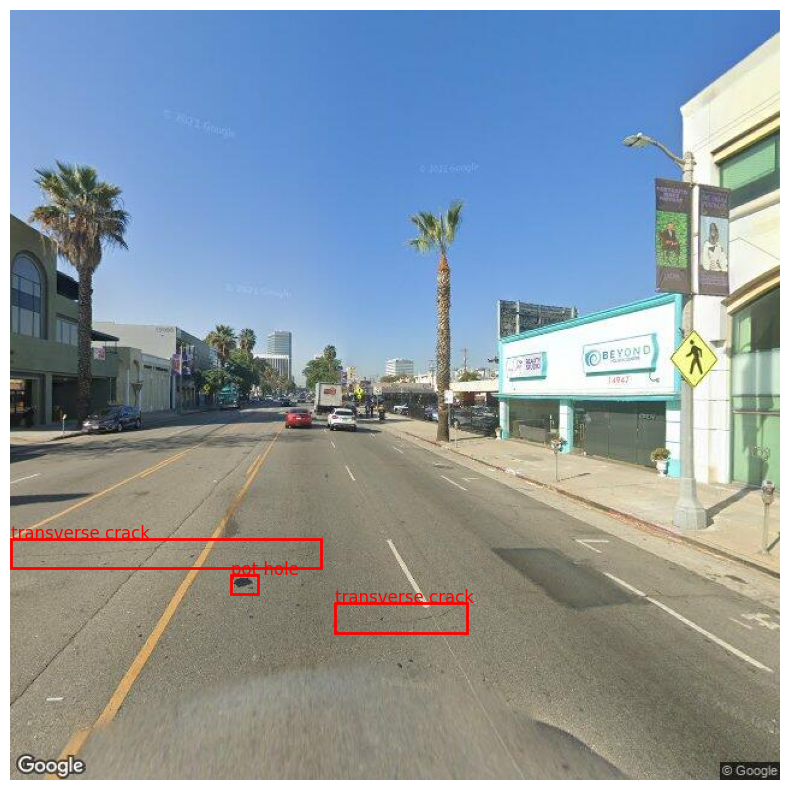

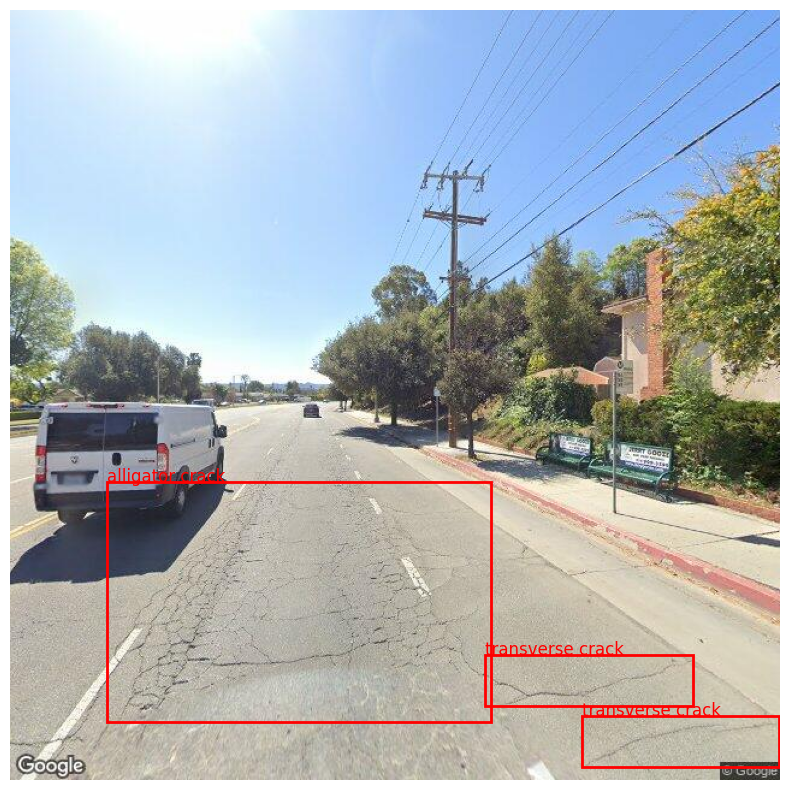

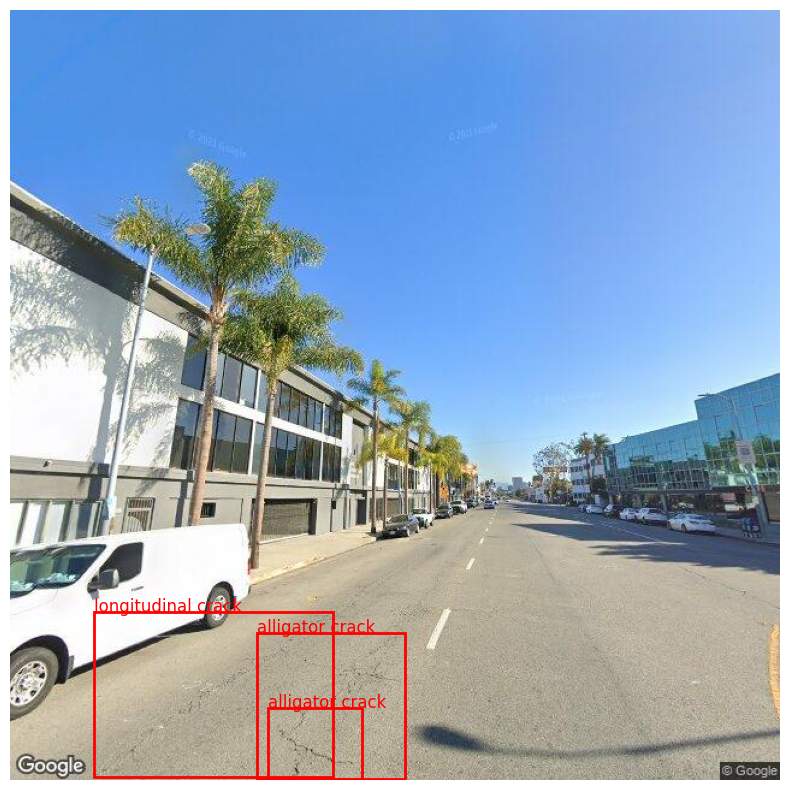

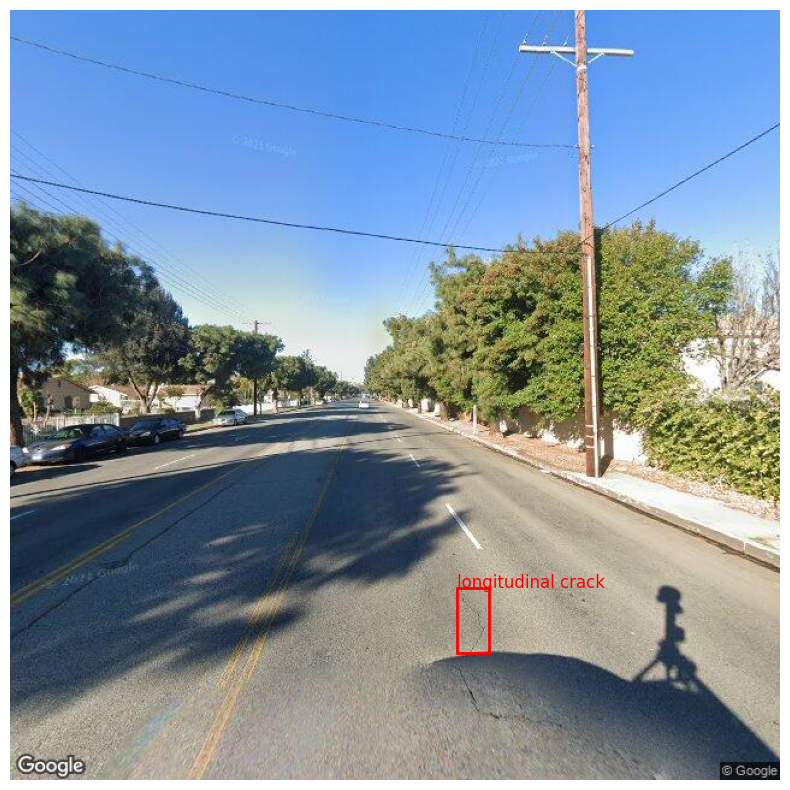

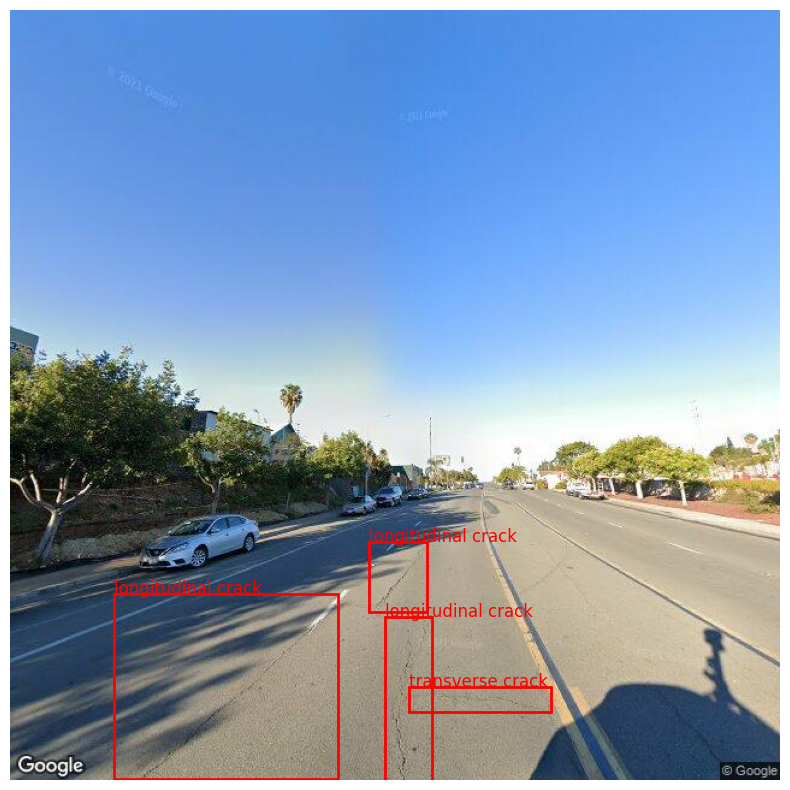

In [6]:
# Open the first image and show the corresponding predictions
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

class_translations = {
    1: 'longitudinal crack',
    2: 'transverse crack',
    3: 'alligator crack',
    4: 'pot hole',
}


for image_num in range(5):
    # Load the image
    image = cv2.imread(PATH + '/' + df['ImageId'].iloc[image_num])
    image_repeat = cv2.imread(PATH + '/' + df_repeats['ImageId'].iloc[image_num])
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_repeat = cv2.cvtColor(image_repeat, cv2.COLOR_BGR2RGB)
    # Get the corresponding predictions
    predictions = df['PredictionString'].iloc[image_num].split(' ')
    predictions_repeat = df_repeats['PredictionString'].iloc[image_num].split(' ')
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    # Plot the bounding boxes
    for i in range(0, len(predictions), 5):
        class_id = int(predictions[i])
        x_min, y_min, x_max, y_max = int(predictions[i+1]), int(predictions[i+2]), int(predictions[i+3]), int(predictions[i+4])
        ax = plt.gca()
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min, class_translations[class_id], fontsize=12, color='r')
    plt.axis('off')
    plt.show()
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_repeat)
    # Plot the bounding boxes
    for i in range(0, len(predictions_repeat), 5):
        class_id = int(predictions_repeat[i])
        x_min, y_min, x_max, y_max = int(predictions_repeat[i+1]), int(predictions_repeat[i+2]), int(predictions_repeat[i+3]), int(predictions_repeat[i+4])
        ax = plt.gca()
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min, class_translations[class_id], fontsize=12, color='r')
    plt.axis('off')
    plt.show()